
# Slim simulations



In [5]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

np.random.seed(7)

Import variables global to the entire analysis:

In [6]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [7]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Plotting setup:

In [8]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

Ignore warnings:

In [9]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code

In [10]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load swept regions

In [11]:
extended_peak_regions_10 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_10%.hdf')
extended_peak_regions_10['chrom'] = 'chrX'
(extended_peak_regions_10.end_pos - extended_peak_regions_10.start_pos).sum()

17500000

## Extract pi on X chromosome for Africans and non-Africans

In [12]:
dist_afr = (pd.read_hdf(ag.steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.hdf')
            .loc[lambda df: (df.region_1 == 'Africa') & (df.region_2 == 'Africa')]
           )
dist_nonafr = (pd.read_hdf(ag.steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.hdf')
            .loc[lambda df: (df.region_1 != 'Africa') & (df.region_2 != 'Africa')]
           )
dist_nonafr.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,...,longitude_1,longitude_2,sex_1,sex_2,region_label_1,region_label_2,region_id_1,region_id_2,region_1,region_2
34144,X,0,100000,NA,B_Crete-2,A,S_Tujia-1,A,0.000000,0,...,NaN,109.000000,XY,XY,WestEurasia,EastAsia,1,5,WestEurasia,EastAsia
130368,X,0,100000,NA,B_Crete-2,A,S_BedouinB-1,A,0.008130,2,...,NaN,35.000000,XY,XY,WestEurasia,WestEurasia,1,1,WestEurasia,WestEurasia
225040,X,0,100000,NA,B_Crete-2,A,S_Burusho-1,A,0.000000,0,...,NaN,74.000000,XY,XY,WestEurasia,SouthAsia,1,2,WestEurasia,SouthAsia
391104,X,0,100000,NA,B_Crete-2,A,S_Punjabi-2,A,0.005882,2,...,NaN,74.300003,XY,XY,WestEurasia,SouthAsia,1,2,WestEurasia,SouthAsia
529232,X,0,100000,NA,B_Crete-2,A,S_Makrani-1,A,0.006154,2,...,NaN,64.000000,XY,XY,WestEurasia,SouthAsia,1,2,WestEurasia,SouthAsia


In [13]:
afr_mean_dist = dist_afr.dist.mean()
nonafr_mean_dist = dist_nonafr.dist.mean()

In [14]:
afr_mean_dist, nonafr_mean_dist, nonafr_mean_dist / afr_mean_dist

(0.0007654295, 0.00046199292, 0.60357344)

## Extract likely pi relative to global pi in Africans

In [15]:
lst = list()
for tup in extended_peak_regions_10.itertuples():
    lst.append(dist_afr.loc[(dist_afr.start >= tup.start_pos) & (dist_afr.end <= tup.end_pos)])
afr_dist_regions = pd.concat(lst)

lst = list()
for tup in extended_peak_regions_10.itertuples():
    lst.append(dist_nonafr.loc[(dist_nonafr.start >= tup.start_pos) & (dist_nonafr.end <= tup.end_pos)])
nonafr_dist_regions = pd.concat(lst)

In [16]:
afr_mean_dist_in_regions = afr_dist_regions.dist.mean()
nonafr_mean_dist_in_regions = nonafr_dist_regions.dist.mean()

In [17]:
afr_mean_dist_in_regions, afr_mean_dist, afr_mean_dist_in_regions / afr_mean_dist

(0.0005436191, 0.0007654295, 0.71021444)

In [18]:
nonafr_mean_dist_in_regions, nonafr_mean_dist, nonafr_mean_dist_in_regions / nonafr_mean_dist

(0.00020587526, 0.00046199292, 0.44562426)

In [19]:
nonafr_mean_dist_in_regions / afr_mean_dist_in_regions, nonafr_mean_dist / afr_mean_dist

(0.37871233, 0.60357344)

If we assume that there has been no sweeps in Africa, this implies that background Ne in the regions is 0.71 of the chromosome average.

## Compute demographies

We simulate 200,000 generations, correspoding to roughly 10 Ne. Most lineages should have coalesced by 6Ne.

This is specfied in the workflow along with the demograpy.

In [20]:
sim_generations = 200000 - 1
x_auto_fraction = 0.55

def years2gen(y):
    return int(1 + sim_generations - y / ag.gen_time)

years2gen(sim_generations * ag.gen_time), years2gen(0), sim_generations * ag.gen_time

(1, 200000, 5799971)

## Slim standard demography

We make a descrete trajectory approximating the demography from Yun Songs paper: Terhorst et al. 2017

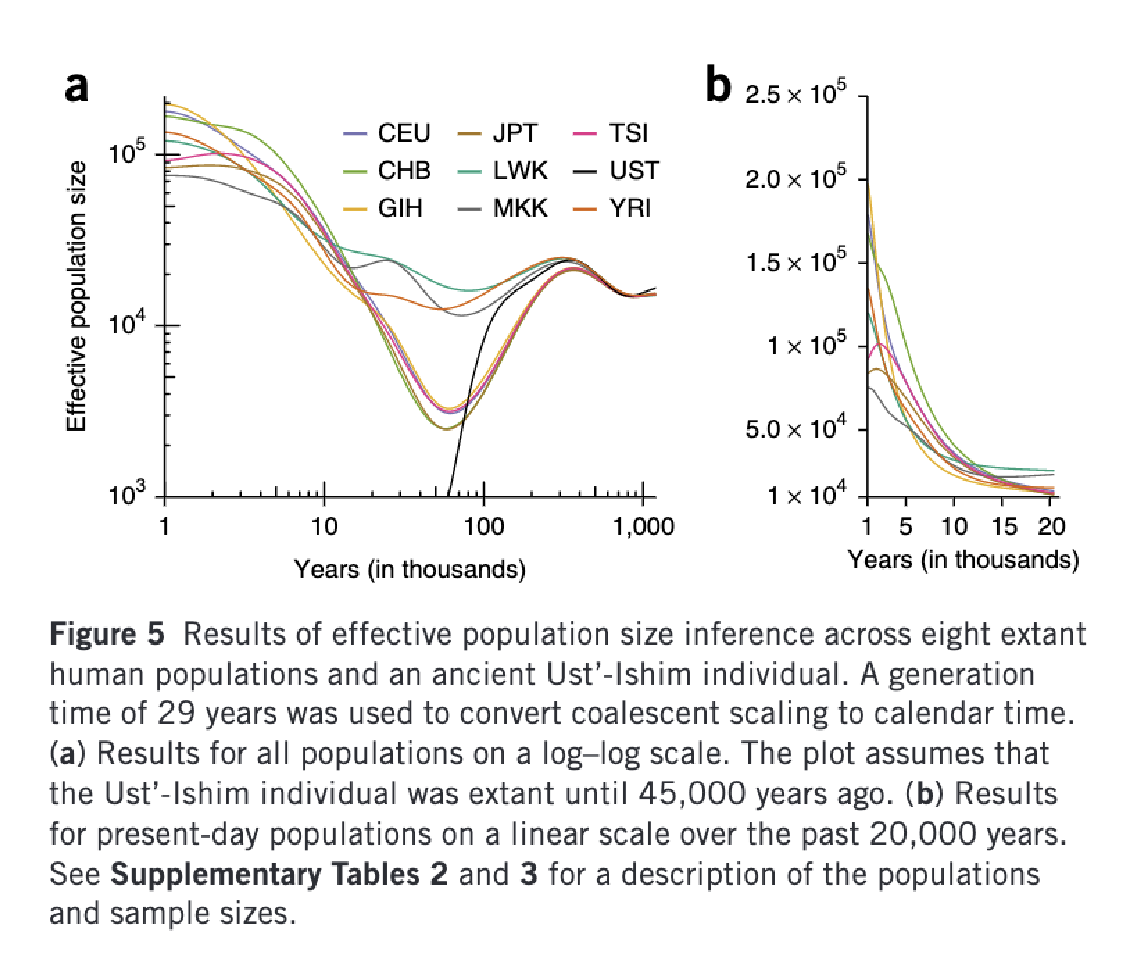

In [21]:
from matplotlib.image import imread
fig, ax = plt.subplots(figsize=(10, 10))
imgplot = ax.imshow(imread('Terhorst2017.png'))
plt.axis('off') ;

In this paper, the demography is based on a mutation rate per generation of 1.25 × 10−8. That is roughly the same as in my analysis:

In [22]:
ag.mut_per_year * ag.gen_time

1.247e-08

Demography is specified as descrete breakpoints and effective population sizes:

In [23]:
changes_year = [sim_generations * ag.gen_time, 700000, 250000, 150000, 100000, 70000, 45000, 35000, 25000, 15000, 8000, 3000]
changes_Ne = [18000, 20000, 12000, 6000, 4000, 3000, 4000, 6000, 12000, 20000, 50000, 100000]

Time points for starts fo simulated sweeps:

In [24]:
sweep_years = [30000, 50000, 70000, 90000]

Adjust population sizes slightly to make the demography produce the the empirical mean 100kb pairwise differences across non-African populations in our data set. This makes most sense since we we want to simulate replicates of the acctual data set.

In [25]:
correction_to_fit_autosomal_pi = 1.09
changes_Ne = [x * correction_to_fit_autosomal_pi for x in changes_Ne]

In [26]:


# changes_year = [sim_generations * ag.gen_time, 250000, 150000, 100000, 70000, 45000, 35000, 25000, 15000, 6000]
# changes_Ne = [20000, 12000, 6000, 4000, 3000, 4000, 6000, 12000, 20000, 100000]

# sweep_years = [30000, 50000, 70000, 100000]

# #changes_Ne = [(x*1.15) for x in changes_Ne]
# changes_year, changes_Ne

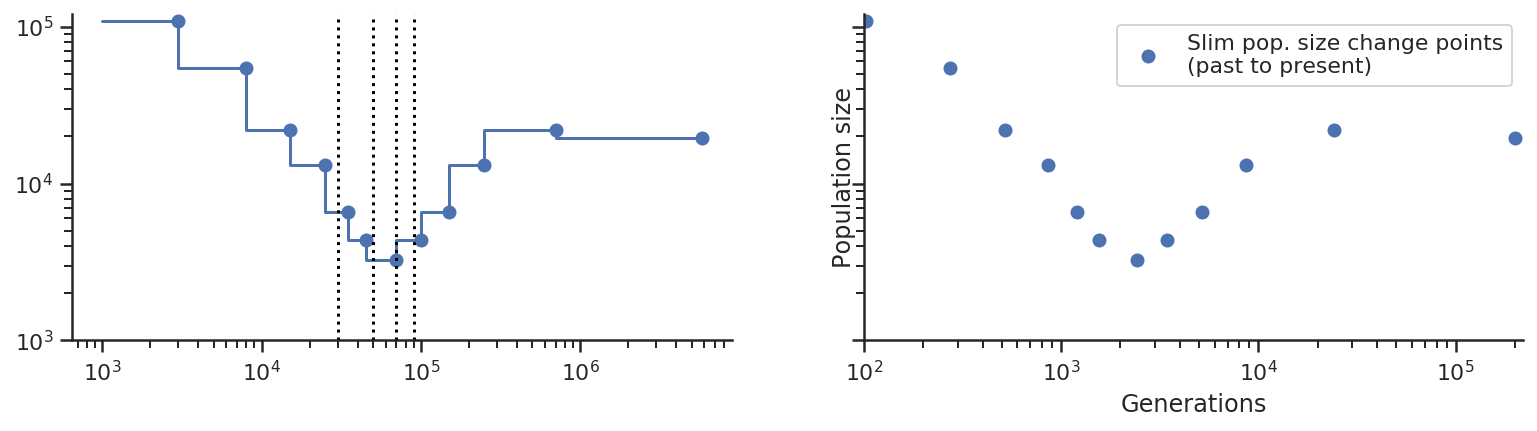

In [27]:
with sns.axes_style('ticks') :

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,3), sharey=True)

    y = Series(list(reversed(changes_year)))
    n = Series(list(reversed(changes_Ne)))
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 1000

    auto_demography = list(zip(reversed(x[1::2]), reversed(y[1::2])))

    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.loglog(x, y, color=color)
    ax1.loglog(*list(zip(*auto_demography)), marker='o', color=color, linestyle='None', label='Autosomes');


    y = Series(list(reversed(changes_year)))
    n = Series(list(reversed(changes_Ne))) * x_auto_fraction
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 1000

    [ax1.axvline(x, linestyle='dotted', color='black') for x in sweep_years]
    
    slim_demography = [(years2gen(y), int(n)) for (y, n) in auto_demography]  ## using auto
    g, n = list(zip(*slim_demography))
    ax2.loglog([sim_generations-x for x in g], n, marker='o', linestyle='None', 
               label='Slim pop. size change points\n(past to present)');
    ax2.set_ylim(1000, 120000)
    ax2.set_xlim(1e2, 2.2e5) ;
    ax2.set_xlabel('Generations')
    ax2.set_ylabel('Population size')
    ax2.legend()

    sns.despine()

We use **autosomal** population sizes for Slim because it models the X chrom explicitly. To make the X/A ratio lower than 0.75 we scale the population sizes by (e.g. 0.66/0.75) when running the slim simulation.

Generation-Ne pairs for changeing population size in Slim simulation (for adding to `workflow.py`):

In [28]:
slim_demography

[(1, 19620),
 (175862, 21800),
 (191379, 13080),
 (194827, 6540),
 (196551, 4360),
 (197586, 3270),
 (198448, 4360),
 (198793, 6540),
 (199137, 13080),
 (199482, 21800),
 (199724, 54500),
 (199896, 109000)]

Generations for sweeps in Slim simulations (for adding to `workflow.py`):

In [29]:
sweep_generations = [years2gen(x) for x in sweep_years]
sweep_generations

[198965, 198275, 197586, 196896]

## Slim truncated demography

Truncate simulation at 45000 years. 

If we then call ECHs with pwdiff of 2 * 10000 * 0.6e-9 = 1.2e-05, we can test if ECH can arise neutrally in 10000 years (from 55000)



In [30]:
changes_year_trunc = [x - 45000 for x in changes_year]
idx = changes_year_trunc.index(0)+1
changes_year_trunc = changes_year_trunc[:idx]
changes_Ne_trunc = changes_Ne[:idx]

In [31]:
def years2gen_trunc(y):
    return int(1 + sim_generations - (45000 / ag.gen_time) - y / ag.gen_time)

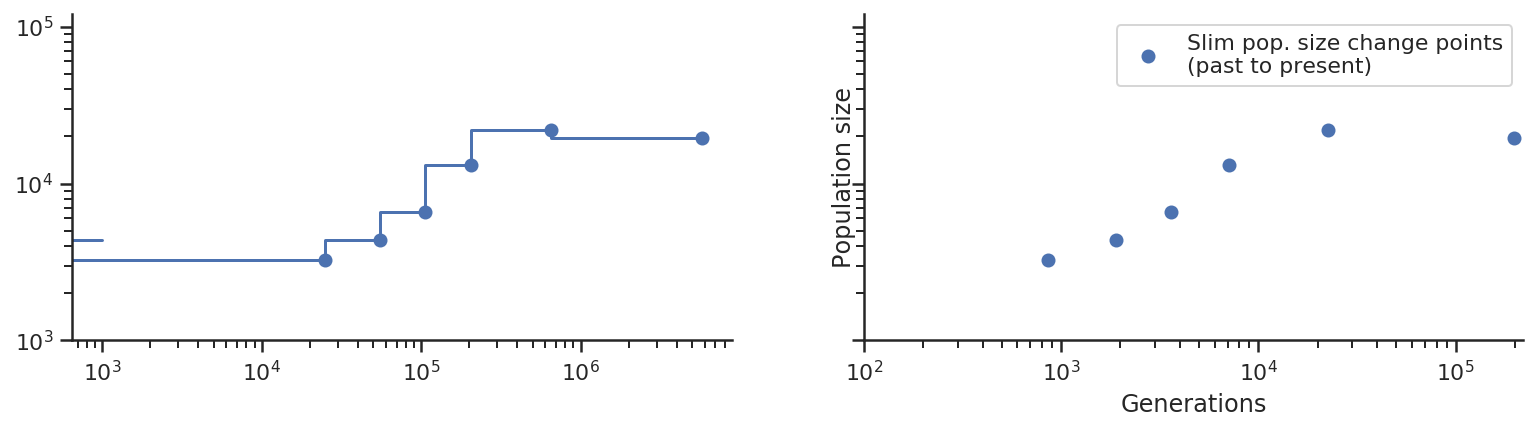

In [32]:
with sns.axes_style('ticks') :

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,3), sharey=True)

    y = Series(list(reversed(changes_year_trunc)))
    n = Series(list(reversed(changes_Ne_trunc)))
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 1000

    auto_demography = list(zip(reversed(x[1::2]), reversed(y[1::2])))

    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.loglog(x, y, color=color)
    ax1.loglog(*list(zip(*auto_demography)), marker='o', color=color, linestyle='None', label='Autosomes');

    y = Series(list(reversed(changes_year_trunc)))
    n = Series(list(reversed(changes_Ne_trunc))) * x_auto_fraction
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 1000
    
    slim_demography_trunc = [(years2gen_trunc(y), int(n)) for (y, n) in auto_demography]  ## using auto
    g, n = list(zip(*slim_demography))
    ax2.loglog([sim_generations-(45000/ag.gen_time)-x for x in g], n, marker='o', linestyle='None', 
               label='Slim pop. size change points\n(past to present)');
    ax2.set_ylim(1000, 120000)
    ax2.set_xlim(1e2, 2.2e5) ;
    ax2.set_xlabel('Generations')
    ax2.set_ylabel('Population size')
    ax2.legend()

    sns.despine()

Generation-Ne pairs for changeing population size in Slim simulation (for adding to `workflow.py`):

In [33]:
slim_demography_trunc

[(1, 19620),
 (175862, 21800),
 (191379, 13080),
 (194827, 6540),
 (196551, 4360),
 (197586, 3270),
 (198448, 4360)]

## Pool-Nielsen computations for sanity checks on demography

Reading off from the plot in Mallick et al., the African X/A pi is 0.66 and the non-African one is 0.55.

In [34]:
epoques = list()
g, n = list(zip(*slim_demography))
gens, Ns = [sim_generations-x for x in g][::-1], n[::-1]
for i in range(len(gens)):
    if i == 0:
        epoques.append((gens[i], Ns[i]))
    elif i == len(gens) - 1:
        epoques.append((None, Ns[i]))    
    else:
        epoques.append((gens[i] - gens[i-1], Ns[i]))
epoques

[(103, 109000),
 (172, 54500),
 (242, 21800),
 (345, 13080),
 (344, 6540),
 (345, 4360),
 (862, 3270),
 (1035, 4360),
 (1724, 6540),
 (3448, 13080),
 (15517, 21800),
 (None, 19620)]

In [35]:
def exp_coal(g, N):
    return 2*N - (g * np.exp(-g/(2*N))) / (1 - np.exp(-g/(2*N)))

def epoch(demog, h, i):
    g, N = demog[i]
    N *= h
    if i == len(demog)-1:
        return 2*N
    return (1-np.exp(-g/(2*N))) * exp_coal(g, N) + np.exp(-g/(2*N)) * (g + epoch(demog, h, i+1))

The effect of X/A ratio seems to be fairly linear for relevant values of X/A in Africans:

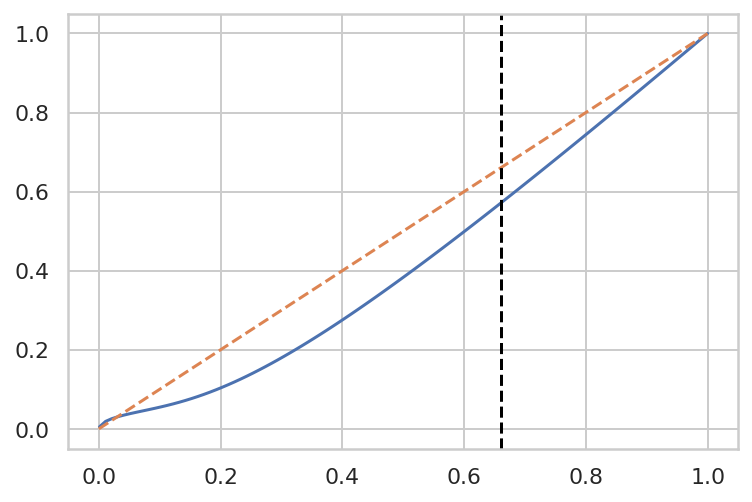

In [36]:
x = np.linspace(0.001, 1, 100)
y = [epoch(epoques, h, 0) / epoch(epoques, 1, 0) for h in x]
plt.plot(x, y) ;
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle='dashed')
plt.axvline(0.66, color='black', linestyle='dashed') ;

Expected non-African autosomal Ne:

In [37]:
epoch(epoques, 1, 0) / 2

14222.540110283435

Expected autosomal pi:

In [38]:
2 * 1.2e-8 * epoch(epoques, 1, 0)

0.0006826819252936048

This matches mean pi across non-African populations which is 0.000683 (see notebook 1).

We do not necessarily expect X chromosome pi to match the expectation from the demography if sweeps play a large role in reducing pi. However, the demography (by Pool-Nielsen effect) does produce an expected non-African X/A pi much like what is reported in Mallick et al.:

In [39]:
epoch(epoques, 0.66, 0) / epoch(epoques, 1, 0)

0.5707517643074761

However, the expected pi on the X is smaller than the observed pairwise difference:

In [40]:
2 * 1.2e-8 * epoch(epoques, 0.66, 0), nonafr_mean_dist

(0.00038964191332214955, 0.00046199292)

Assuming that African pi is 0.73 lower than global pi on X, we can compute expected pi of ECH regions in non-Africans. For what it si worth, this is a bit bigger than the observed mean pairwise distances in ECH regions.

In [41]:
2 * 1.2e-8 * epoch(epoques, 0.66*0.73, 0), nonafr_mean_dist_in_regions

(0.0002476955491681802, 0.00020587526)

## Find recombination rates relevant for simulations

Lift over regions to hg38

In [42]:
print(extended_peak_regions_10[['chrom', 'start_pos', 'end_pos']].to_string(index=False))

chrom  start_pos    end_pos
chrX   19300000   20400000
chrX   20700000   21700000
chrX   35900000   37100000
chrX   37000000   37800000
chrX   49500000   50000000
chrX   50800000   51300000
chrX   53900000   54700000
chrX   64400000   65200000
chrX   72700000   73500000
chrX   73800000   74400000
chrX   76700000   77400000
chrX   98300000   99200000
chrX  109200000  111600000
chrX  113800000  114500000
chrX  126400000  127700000
chrX  129500000  130200000
chrX  130900000  132300000
chrX  132400000  133100000
chrX  153900000  154500000


Used online liftover to convert to hg38 allowing, checking box to allow multiple output regions. Pasted in below:

In [43]:
lifted = '''
chrX	19281882	20381882	chrX:19300001-20400000	1
chrX	20681882	21681882	chrX:20700001-21700000	1
chrX	35881883	37080183	chrX:35900001-37100000	1
chrX	50057375	50057403	chrX:49500001-50000000	1
chrX	51057154	51557148	chrX:50800001-51300000	1
chr2	33174181	33174306	chrX:50800001-51300000	2
chrX	53873573	54673567	chrX:53900001-54700000	1
chrX	65180120	65980158	chrX:64400001-65200000	1
chrX	73480164	74280165	chrX:72700001-73500000	1
chrX	74580165	75180165	chrX:73800001-74400000	1
chrX	77448201	78144503	chrX:76700001-77400000	1
chrX	99045002	99945002	chrX:98300001-99200000	1
chrX	109956772	112356772	chrX:109200001-111600000	1
chrX	114565551	115265429	chrX:113800001-114500000	1
chrX	78550431	78550462	chrX:113800001-114500000	2
chrX	114761888	114761918	chrX:113800001-114500000	3
chrX	114761888	114761980	chrX:113800001-114500000	4
chrX	127266017	128566022	chrX:126400001-127700000	1
chrX	130366026	131066026	chrX:129500001-130200000	1
chrX	131765972	133165972	chrX:130900001-132300000	1
chrX	133265972	133965973	chrX:132400001-133100000	1
chrX	154671726	155270710	chrX:153900001-154500000	1
'''

Conversion failed for :

    #Partially deleted in new
    chrX	37000000	37800000

Extract recombination rates for regions:

In [44]:
records = list()
for row in lifted.strip().split('\n'):
    records.append([x.isdigit() and int(x) or x for x in row.split()])
extended_peak_regions_10_hg38 = pd.DataFrame.from_records(records, 
                                    columns=['chrom', 'start', 'end', 'segment', 'piece'])
extended_peak_regions_10_hg38.head()

,chrom,start,end,segment,piece
0,chrX,19281882,20381882,chrX:19300001-20400000,1
1,chrX,20681882,21681882,chrX:20700001-21700000,1
2,chrX,35881883,37080183,chrX:35900001-37100000,1
3,chrX,50057375,50057403,chrX:49500001-50000000,1
4,chrX,51057154,51557148,chrX:50800001-51300000,1


Load recombination rate from Halldorsson et al. 2019: "Characterizing mutagenic effects of recombination through a sequence-level genetic map". Rates are per generation, also for the X chromosome (i.e. the maternal rate and sex average rates are the same).

#decode_hg38_sexavg_per_gen.tsv

In [45]:
decode_sexavg = pd.read_table(ag.data_dir / 'decode_hg38_sexavg_per_gen.tsv', comment='#')
decode_sexavg.head()

,Chr,Begin,End,cMperMb,cM
0,chr1,1431813,1515567,0.032449,0.002718
1,chr1,1515567,1530002,0.189597,0.005455
2,chr1,1530002,1534402,0.004631,0.005475
3,chr1,1534402,1538787,0.019865,0.005562
4,chr1,1538787,1541864,0.000332,0.005563


Mean rate for entire chromosome without PARs:

In [46]:
decode_sexavg_chrX = (decode_sexavg
                      .loc[(decode_sexavg['Chr'] == 'chrX') & \
                           (decode_sexavg['Begin'] > ag.par1_end) & (decode_sexavg['End'] < ag.par2_start)]
                     )
mean_rate = np.average(decode_sexavg_chrX.cMperMb, weights=decode_sexavg_chrX.End-decode_sexavg_chrX.Begin)
mean_rate

1.1628671122887646

In [47]:
lst = list()
for tup in extended_peak_regions_10_hg38.itertuples():
    lst.append(decode_sexavg_chrX.loc[(decode_sexavg_chrX.Begin >= tup.start) & \
                                         (decode_sexavg_chrX.End <= tup.end)])
df = pd.concat(lst).assign(length=lambda df: df.End-df.Begin)

In [48]:
# x = 0
# for tup in df.itertuples():
#     x += tup.length / tup.cMperMb
# df.cMperMb.sum() / x

In [49]:
region_rates = list()
for tup in extended_peak_regions_10_hg38.itertuples():
    df = decode_sexavg_chrX.loc[(decode_sexavg_chrX.Begin >= tup.start) & \
                                         (decode_sexavg_chrX.End <= tup.end)]
    try:
        print(np.average(df.cMperMb, weights=df.End-df.Begin), (df.End-df.Begin).sum())
    except:
        print('no data')
    region_rates.append(df.cMperMb.mean())
#region_rates

0.7714960806657281 1090037
0.14799578821239454 995497
0.59996324488122 1174337
no data
0.3881414330086544 460999
no data
0.6182831047948463 796095
0.06045129886415356 787887
0.055369445184570265 754082
0.033365123098329924 478934
0.16385733180749762 324006
0.37963386659341497 831524
1.0506992925429448 2388712
0.24534543815666665 677993
no data
no data
no data
0.1787357894815154 1289547
0.3962461007976023 696481
0.25158823039985084 1369438
0.4624944813468881 670944
3.6575361107825273e-37 104876


Mean (sex averaged) per-generation recombination rate for all the regions:

In [50]:
df_list = list()
for tup in extended_peak_regions_10_hg38.itertuples():
    df_list.append(decode_sexavg_chrX.loc[(decode_sexavg_chrX.Begin >= tup.start) & (decode_sexavg_chrX.End <= tup.end)])
df = pd.concat(df_list)

In [51]:
extended_peak_regions_10_mean_rate = np.average(df.cMperMb, weights=df.End-df.Begin)
extended_peak_regions_10_mean_rate

0.44828514994584506

Mean per-meiosis recombination rate for all the regions (taking into account that only 2/3 of X chromosome can recombine in each generation):

In [52]:
extended_peak_regions_10_mean_rate * 3 / 2

0.6724277249187676

## Distribution of recombination rate in 1Mb windows along X chromosome

In [53]:
decode_sexavg_chrX.head()

,Chr,Begin,End,cMperMb,cM
1122949,chrX,3532526,3533229,2.641418e-01,0.000186
1122950,chrX,3533229,3534231,1.352181e+00,0.001541
1122951,chrX,3534231,3535643,2.552302e-64,0.001541
1122952,chrX,3535643,3551002,2.618438e-60,0.001541
1122953,chrX,3551002,3580516,1.997509e-54,0.001541


In [54]:
@window(size=1000000)
def mean_window_rate(df):
    if len(df):
        return np.average(df.cMperMb, weights=df.end-df.start)
    else:
        return np.nan

mb_window_means = mean_window_rate(decode_sexavg_chrX.rename(columns={'Begin':'start', 'End':'end'}))
mb_window_means.head()

,start,end,mean_window_rate
0,0,1000000,NaN
1,1000000,2000000,NaN
2,2000000,3000000,NaN
3,3000000,4000000,1.791569
4,4000000,5000000,0.955587


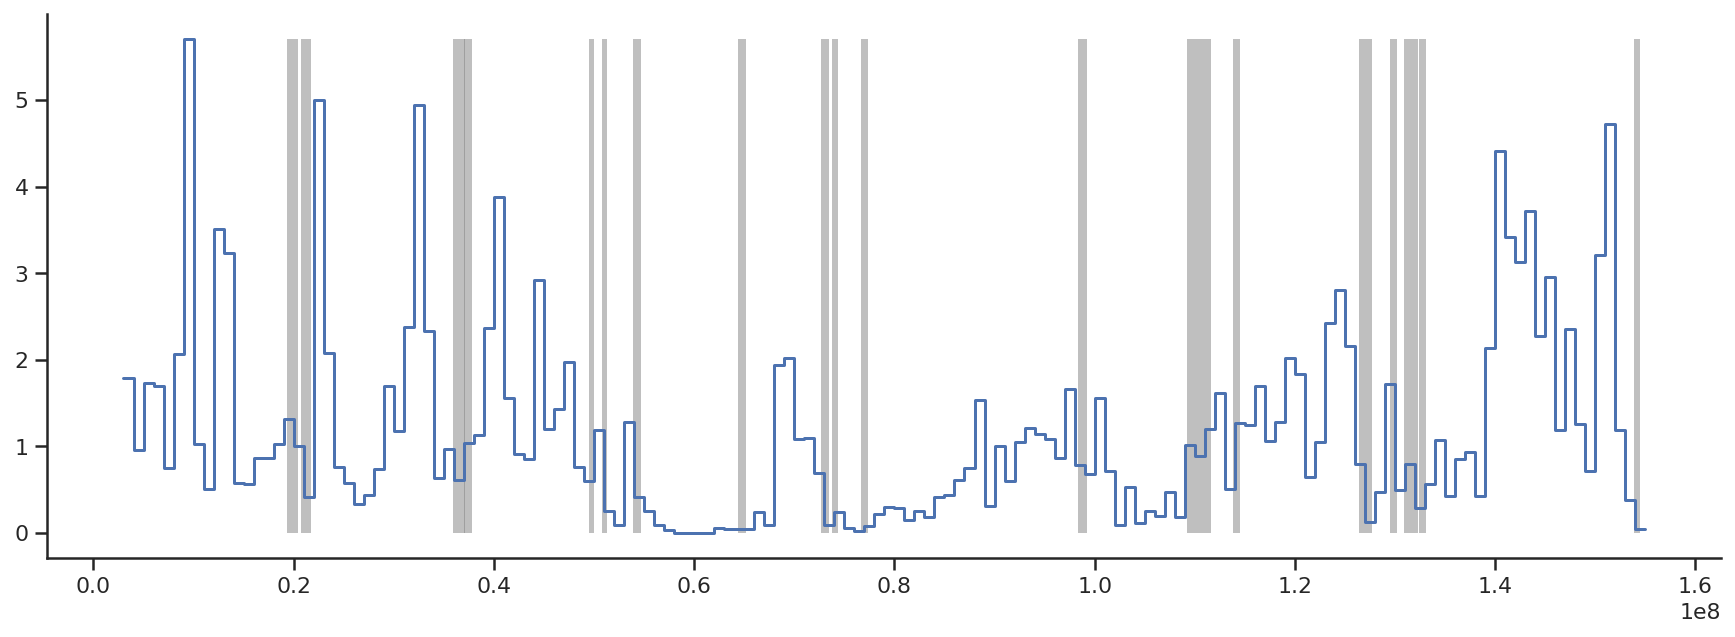

In [55]:
with sns.axes_style('ticks'):
    plot_df = stairs(mb_window_means)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    for tup in extended_peak_regions_10.itertuples():
        g = ax.add_patch(Rectangle((tup.start_pos, 0), 
                                   tup.end_pos-tup.start_pos, plot_df.mean_window_rate.max(), 
                     facecolor='gray',
                     linewidth=0,
                     alpha=0.5,
                     zorder=0))
    plt.plot(plot_df.pos, plot_df.mean_window_rate)
    sns.despine()

So although the ECH regions have lower recombination rate, they are not uniquely low. There are plenty other regions that are equally low.

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


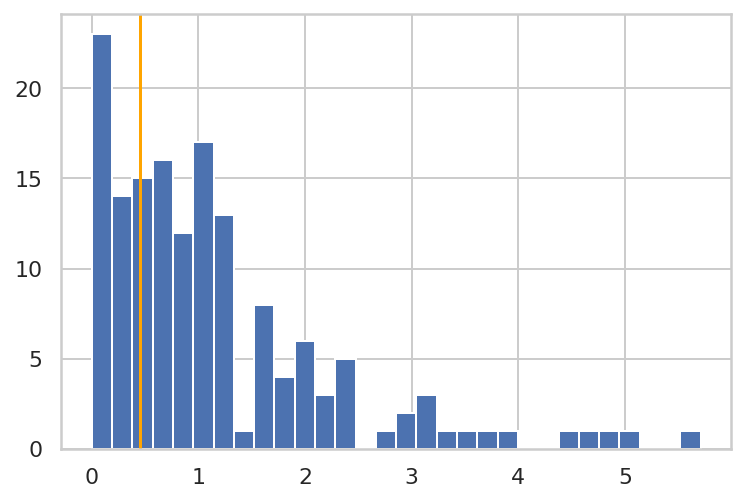

In [56]:
plt.hist(mb_window_means.mean_window_rate, bins=30)
plt.axvline(extended_peak_regions_10_mean_rate, color='orange') ;

So there are 44 Mb windows with a recombination rate that is lower than the mean for the 10% regions. For comparison the 10% regions make up only 17.5 Mb in total:

In [57]:
len(mb_window_means.loc[mb_window_means.mean_window_rate <= extended_peak_regions_10_mean_rate])

44

In [58]:
(extended_peak_regions_10.end_pos - extended_peak_regions_10.start_pos).sum() / 1000000

17.5

## Simulation strategy

We do two sets of simulations:

1. Assuming that global averages for chrX:
    - We simulate with Ne_autosome * 3/4 * 0.66 The latter is the X/A ratio of Africans, which should capture the various demographic forces reducing Ne on X below 3/4.
    - We simulate with the mean recombination rate for X.
2. Assuming the averages for the swept regions:
    - We further reduce Ne by how much ECH region pi it is lower than the chrX mean.
    - We further reduce recombination rate by how much ECH region rate it is lower than the chrX mean.


When we compute the probability of obtaining an ECH in the latter scenario, we need to take into account that only a small part of the X has an Ne that is this low.

## Load data for sweeps called on simulations

In [59]:
prop_swept_data = pd.read_hdf(str(ag.steps_dir / 'slim' / 'slim_summary.hdf'))
prop_swept_data['prop_swept'] = prop_swept_data.nr_swept / prop_swept_data.total
prop_swept_data.head()

,start,end,nr_swept,total,demography,x_auto_ratio,rec_rate_per_gen,sweep_start,sweep_type,selcoef,replication,min_clade_percent,prop_swept
0,0,100000,0,140,test,0.66,4.500000e-09,198275,nosweep,0.0,0,25,0.0
1,100000,200000,0,140,test,0.66,4.500000e-09,198275,nosweep,0.0,0,25,0.0
2,200000,300000,0,140,test,0.66,4.500000e-09,198275,nosweep,0.0,0,25,0.0
3,300000,400000,0,140,test,0.66,4.500000e-09,198275,nosweep,0.0,0,25,0.0
4,400000,500000,0,140,test,0.66,4.500000e-09,198275,nosweep,0.0,0,25,0.0


In [72]:
# df = pd.read_hdf(ag.root_dir / 'steps/slim/sweep_data/test_66_4500_X_nosweep_198275_0_0/5e-05/clique_data_5e-05_25%.hdf')
df = pd.read_hdf(ag.root_dir / 'steps/slim/sweep_data/test_66_11600_X_nosweep_198275_0_0/5e-05/clique_data_5e-05_25%.hdf')
#df = pd.read_hdf(ag.root_dir / 'steps/slim/sweep_data/test_48_4500_X_nosweep_198275_0_0/5e-05/clique_data_5e-05_25%.hdf')
#df = pd.read_hdf(ag.root_dir / 'steps/slim/sweep_data/test_48_11600_X_nosweep_198275_0_0/5e-05/clique_data_5e-05_25%.hdf')

df.head()


,indiv_1,start,end,mean_dist,prop_indivs_missing,win_swept,called,clade_mean_dist,clade_size,run_id,run_length,swept
0,0,0,100000,0.001529,0.0,False,False,NaN,5,1,100,False
1,0,100000,200000,0.001529,0.0,False,False,NaN,5,1,100,False
2,0,200000,300000,0.001647,0.0,False,False,NaN,4,1,100,False
3,0,300000,400000,0.001870,0.0,False,False,NaN,4,1,100,False
4,0,400000,500000,0.001572,0.0,False,False,NaN,4,1,100,False


In [71]:
4 * 8800 * 1.2e-8

0.0004224

## Facet plotting function

In [61]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
    plt.ylim((0, 1.1))
    plt.fill_between(x, 0, y, color='gray', alpha=0.05)

## Neutral simulations

Standard demography:

In [62]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard')]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

IndexError: index -1 is out of bounds for axis 0 with size 0

<Figure size 0x0 with 0 Axes>

Truncated demography:

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'truncated')]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'complete') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.1) ]

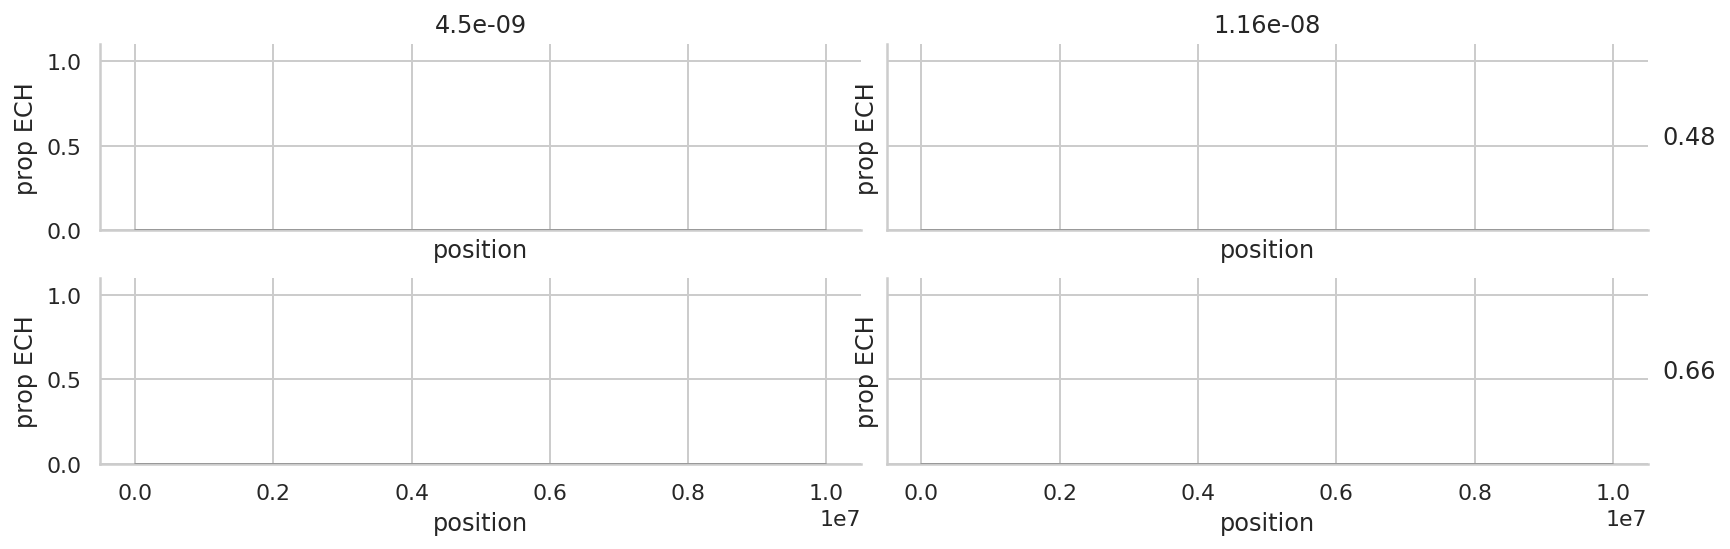

In [65]:
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

-----

In [63]:
with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.str.startswith('standard_40_4650')],
                      col='selection_coef', row='simulation', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=3, aspect=5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



AttributeError: 'DataFrame' object has no attribute 'simulation'

In [ ]:
prop_swept_data.simulation.unique()

In [ ]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
#    plt.plot(x, y, linewidth=0.2, **kwargs)
    plt.ylim((0, 1))
    plt.fill_between(x, 0, y, color='gray', alpha=0.5)

with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.isin(['standard_55_4650_X_nosweep_98275',
                                                                          'standard_40_4650_X_nosweep_98275',
                                                                          'standard_48_4650_X_nosweep_98275',
                                                                          'standard_66_4650_X_nosweep_98275'])],
                      col='replication', row='simulation', sharex=True, sharey=True, margin_titles=True,
                     height=4, aspect=0.5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



## Frequency of derived variants in simulated ECHs

- Extract simulated ECHs as you did in notebook 24 on Moi's data.
- Compute same derived stats and compare simulations and observations.






## TMRCA computations

In [8]:
# from math import exp

# def lamb(i):
#     # lamb(i) rate of coalescence from i-1 to i
#     i += 1
#     return i*(i-1)/2

# samples = 5 # total samples
# setsize = 3 # size of clade (we want to see at least one such clade coalesce before time t)
# t = 1

# for n in range(setsize, samples+1):
#     # loop from setsize to samples (3 to 5):
#     p = 0
#     for i in range(1, n):
#         # loop from 1 to n-1:
#         p += np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n) if i != j]) \
#         * exp(-lamb(n)*t) \
#         * (lamb(i)/(lamb(i)-lamb(n))) \
#         * (-exp(-(lamb(i)-lamb(n))*t) + 1)
#     # combinatorial expression:
#     p *= scipy.misc.comb(n, setsize) / scipy.misc.comb(samples, setsize)
# p
    


In [9]:
# def lamb(x):
#     x += 1
#     return x*(x-1)/2


# N = 3000
# n = 42
# t = 1

# prob = 0
# for i in range(1, n):
#     prob += (1 - math.exp(-lamb(i)*t)) * np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n) if i != j])
# prob * scipy.misc.comb(140, 42)

In [10]:
#scipy.misc.comb(140, 42)

In [11]:
#1- math.exp(-lamb(1))

In [12]:
# def lamb(x):
#     return x*(x-1)/2

# t = 10
# n = 20

# prob = 0
# for i in range(1, n+1):
# #     print([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n+1) if i != j])
#     prob += lamb(i) * math.exp(-lamb(i)*t) * np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n+1) if i != j])
# prob #* scipy.misc.comb(n, i)

In [13]:
#lamb(3)

In [14]:
# import scipy

# def coal_n_to_l(n, l, t):
#     """Prob of reducing n lineages to l in time t"""
#     Q = np.zeros(shape=(n-l+1, n-l+1))
#     for x in range(n-l):
#         rate = scipy.misc.comb(n-x, 2) / (2 * pop_size)
#         Q[x][x] = -rate
#         Q[x][x+1] = rate
#     return scipy.linalg.expm(Q*t)[0][-1]

# def clade_prob(n, l, t, i):
#     """Prob of one among l lineages being ancestor to i among n"""
# #     if i == 1 or l == 1:
# #         return 1
# #     else:
#     return scipy.misc.comb(n-i-1, l-2) / scipy.misc.comb(n-1, l-1)
        
# n = 5
# t = 36
# pop_size = 300
# i = 2

# total_prop = 0
# for l in range(1, n):
#     total_prop += coal_n_to_l(n, l, t) * clade_prob(n, l, t, i)
# total_prop

In [15]:
# n = 5
# t = 360
# pop_size = 30

# i = 2

# #l = 3

# total_prop = 0

# for l in [3]:#range(1, n):
    
#     # probability of having l out of n left at time t
#     Q = np.zeros(shape=(n-l+1, n-l+1))
#     for x in range(n-l):
#         rate = scipy.misc.comb(n-x, 2) / (2 * pop_size)
#         Q[x][x] = -rate
#         Q[x][x+1] = rate
#     prop_coalescences_n_to_l = scipy.linalg.expm(Q*t)[0][-1]
#     prop_coalescences_n_to_l

    
#     if i == 1 or l == 1:
#         prop_ancestor_to_i = 1 # CHECK THAT THIS IS OK
#     else:
#         prop_ancestor_to_i = scipy.misc.comb(n-i-1, l-2) / scipy.misc.comb(n-1, l-1)

#     assert prop_ancestor_to_i <= 1, prop_ancestor_to_i

#     prob = prop_coalescences_n_to_l * prop_ancestor_to_i

#     print(prop_coalescences_n_to_l, prop_ancestor_to_i)

#     total_prop += prob
# total_prop

## Not sure what the stuff below is

In [ ]:
df = pd.read_hdf(str(ag.steps_dir / 'slim/simulations/standard/66/4650/X/nosweep/98275/10/standard_66_4650_X_nosweep_98275_10_0.hdf'))

plt.hist(df.dist, bins=100, alpha=0.5) ;
plt.axvline(5e-5, color='orange', linestyle='dashed') ;


In [ ]:
df = pd.read_hdf(str(ag.steps_dir / 'slim/simulations/standard/48/4650/X/nosweep/98275/10/standard_48_4650_X_nosweep_98275_10_0.hdf'))

plt.hist(df.dist, bins=100, alpha=0.5) ;
plt.axvline(5e-5, color='orange', linestyle='dashed');


In [ ]:
# s = 'standard_40_4650_X_nosweep_98275_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=200, alpha=0.5) ;

# s = 'standard_40_4650_X_nosweep_98275_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=200, alpha=0.5) ;

In [ ]:
# s = 'nosweep_10000_96551_98965_10000_96206_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=200, alpha=0.5) ;

# s = 'nosweep_10000_96551_98965_1000_96206_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=200, alpha=0.5) ;

# s = 'nosweep_10000_96954_98563_690_98275_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=200, alpha=0.5) ;

# s = 'nosweep_10000_97356_98160_357_99310_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=100, alpha=0.5) ;


In [ ]:


s = 'nosweep_10000_3448_5861_10000_5171_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=100, alpha=0.5) ;


In [ ]:
s = 'nosweep_10000_3447_5861_1000_3102_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;

s = 'nosweep_10000_3448_5861_10000_3102_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;


In [ ]:
s = 'nosweep_10000_3447_5861_1000_3102_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=100) ;

In [ ]:
plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    df = pd.read_hdf(f_name_tmpl.format(i))
    plt.hist(df.dist, bins=100)
    plt.axvline(5e-5, color='orange', zorder=0)

In [ ]:
import pyslim, msprime, random
seed = 7
mutation_rate = 1.25e-8
sample_size = 100

trees = pyslim.load(f_name_tmpl.format(0).replace('.hdf', '.trees'))

# Overlay neutral mutations and make bit arrays for each SNP:
sample_ids = sorted(random.sample(list(trees.samples()), sample_size))

trees_sample = trees.simplify(samples=sample_ids, filter_zero_mutation_sites=True, filter_individuals=True)
mutated_trees = msprime.mutate(trees_sample, rate=mutation_rate, random_seed=seed)
# mutated.dump("./sweep_overlaid.trees") 
print(mutated_trees.pairwise_diversity() / mutated_trees.sequence_length)


ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos
plt.figure(figsize=(10,3))
plt.plot(height_for_pos, linewidth=0.5, color='black') ;


trees = pyslim.load(f_name_tmpl.format(1).replace('.hdf', '.trees'))

# Overlay neutral mutations and make bit arrays for each SNP:
sample_ids = sorted(random.sample(list(trees.samples()), sample_size))

trees_sample = trees.simplify(samples=sample_ids, filter_zero_mutation_sites=True, filter_individuals=True)
mutated_trees = msprime.mutate(trees_sample, rate=mutation_rate, random_seed=seed)
# mutated.dump("./sweep_overlaid.trees") 
print(mutated_trees.pairwise_diversity() / mutated_trees.sequence_length)


ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos

plt.plot(height_for_pos, linewidth=0.5, color='red') ;







## Run slim testing to get pairwise distances for testing purposes

In [ ]:
from itertools import combinations
import argparse
import random
import subprocess
import re, os, sys
import tempfile
import numpy as np
import pandas as pd
from pandas import DataFrame
import msprime, pyslim

trees_file = "/home/kmt/simons/faststorage/people/kmt/test_slim.trees"

slurm_script = r'''
initialize() {
	initializeTreeSeq();
	initializeMutationRate(0);
	initializeMutationType("m1", 0.5, "f", 0.0);
	initializeGenomicElementType("g1", m1, 1.0);
	initializeGenomicElement(g1, 0, 10e6-1);
	initializeRecombinationRate(1e-8);
}
1 {
	defineConstant("simID", getSeed());
	sim.addSubpop("p1", 10000);
}
50000 {
    sim.treeSeqOutput("OUTFILE");
	sim.simulationFinished();
}
'''.replace('OUTFILE', trees_file)

print(slurm_script)
random.seed(7)

window_size = 100000

# write slim script file with the right output name
slurm_script_file = tempfile.NamedTemporaryFile(mode='w', delete=False)
slurm_script_file.write(slurm_script)
slurm_script_file.close()

# run slim
cmd = '/home/kmt/simons/faststorage/people/kmt/slim {}'.format(slurm_script_file.name)
p = subprocess.Popen(cmd.split(), 
    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = p.communicate()
print(stdout.decode())
print(stderr.decode())

In [ ]:
mutationrate = 4.3e-10
generationtime = 29

# load trees from slim
ts = pyslim.load(trees_file)

# overlay mutations
mutated_ts = msprime.mutate(ts, rate=mutationrate*generationtime, random_seed=2, keep=True)

In [ ]:
ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos
plt.figure(figsize=(10,3))
plt.plot(height_for_pos, linewidth=0.5, color='black') ;

height_for_pos.mean()

In [ ]:
samples = 10

# random indexes for samples
sample_idx = set(random.sample(range(ts.num_individuals), samples))
assert len(sample_idx) == samples

In [ ]:
# get the corresponding sample haplotypes
sample = list()
for i, hap in enumerate(mutated_ts.haplotypes()):
    if i in sample_idx:
        sample.append(hap)        

In [ ]:
        
# get the positions of each segregating site
positions = [site.position for site in mutated_ts.sites()]  

# make table with sampled haplotypes
table = np.array([list(map(np.int8, hap)) for hap in sample]).transpose()

In [ ]:
# turn table into dataframe with positions
df = DataFrame(table, dtype='int8')
df['pos'] = positions

In [ ]:
# add a row with zeros for the start of each window so there is at least
# one row in each window
zeros = dict((x, 0) for x in range(samples))
extra_df = pd.DataFrame({'pos': range(0, int(mutated_ts.sequence_length), window_size), **zeros})
df = df.append(extra_df)

In [ ]:
# make a start column grouping all rows in same window
df['start'] = ((df.pos // window_size) * window_size).astype('uint32')
df.drop('pos', axis=1, inplace=True)
df.set_index('start', inplace=True)

def pw_dist(df):
    "computes differences bewteen all pairs in a window"
    pairs = list(combinations(df.columns, 2))
    site_diffs = [np.bitwise_xor(df[p[0]], df[p[1]]) for p in pairs]
    return pd.concat(site_diffs, axis=1, keys=pairs).sum()

# make a dataframe with distance for each pair
pw_dist_df = (
    df
    .groupby('start')
    .apply(pw_dist)
    .reset_index()
    .melt(id_vars=['start'], var_name=['indiv_1', 'indiv_2'], value_name='dist')
    )

In [ ]:
# compute proper distance as number of diffs divided by window size
pw_dist_df['dist'] /= window_size

# add end column
pw_dist_df.insert(loc=1, column='end', value=pw_dist_df.start + window_size)

# convert indiv labels from object to int and and write hdf
pw_dist_df['indiv_1'] = pw_dist_df['indiv_1'].astype('uint16')
pw_dist_df['indiv_2'] = pw_dist_df['indiv_2'].astype('uint16')
#pw_dist_df.to_hdf(args.hdf_file, 'df', format='table', mode='w')

In [ ]:
plt.hist(pw_dist_df.dist) 
plt.axvline(5e-5, color='orange') ;